In [66]:
%cd C:\Users\yukir\Documents\Monicas_workspace\py_storage

C:\Users\yukir\Documents\Monicas_workspace\py_storage


In [67]:
from basic_preprocessing import *

In [68]:
from deeplearning_check import *

In [69]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Sign detection\classification

C:\Users\yukir\Documents\Monicas_workspace\Sign detection\classification


In [2]:
IMG_SIZE = 100
NUM_EPOCHS = 8
NUM_CLASSES = 2
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 
opt =  tf.optimizers.Adam()

In [3]:
def create_model():
  #resnet_weights_path = '/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5'
  #resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

  #weigths = weights=resnet_weights_path ->none
  resnet = ResNet50(include_top=False, pooling='avg', weights = None)
  #resnet.summary()
  my_new_model = Sequential()
  my_new_model.add(resnet)
  my_new_model.layers[0].trainable = True
  my_new_model.add(Dense(NUM_CLASSES, activation='softmax')) #dense 3, NUM_CLASSES = 3

  # Say no to train first layer (ResNet) model. It is already trained
    
  opt =  tf.optimizers.Adam()
   #opt바꾼거 확인해
  my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return my_new_model

In [4]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\classification'

In [5]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

#     data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                 width_shift_range=0.1,
#                                 height_shift_range=0.1,
#                                 #sear_range=0.01,
#                                 zoom_range=[0.9, 1.25],
#                                 horizontal_flip=False,
#                                 vertical_flip=False,
#                                 data_format='channels_last',
#                                 brightness_range=[0.5, 1.5]
#                                )

    data_gen_default = ImageDataGenerator(rescale=1./255)
                                       
    train_generator = data_gen_default.flow_from_directory(preprocessing_function=preprocess_input,
            'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_gen_default.flow_from_directory(preprocessing_function=preprocess_input,
            'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\val',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
    
    ## test_gen에는  이미지 증대사용하면 안됨
    test_generator = data_gen_default.flow_from_directory(preprocessing_function=preprocess_input,
            'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps = 1 
            #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return H, model, train_generator, validation_generator ,test_generator

In [6]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [7]:
def get_labels( test_generator ):
    test_generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [60]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)

In [9]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()

In [62]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1]- 600 # 위치
    cv2.putText(frame, class_string, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [63]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

#### Training

In [14]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Found 2968 images belonging to 2 classes.
Found 370 images belonging to 2 classes.
Found 374 images belonging to 2 classes.
Epoch 1/8
39/38 [==============================] - 6s 148ms/step - loss: 1.0742 - accuracy: 0.7635 - val_loss: 0.1518 - val_accuracy: 1.0000
Epoch 2/8
39/38 [==============================] - 4s 103ms/step - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0.3069 - val_accuracy: 1.0000
Epoch 3/8
39/38 [==============================] - 4s 103ms/step - loss: 0.0395 - accuracy: 0.9892 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 4/8
39/38 [==============================] - 4s 103ms/step - loss: 0.0166 - accuracy: 0.9933 - val_loss: 9.8939e-05 - val_accuracy: 1.0000
Epoch 5/8
39/38 [==============================] - 4s 104ms/step - loss: 0.2423 - accuracy: 0.9481 - val_loss: 51.0232 - val_accuracy: 0.0000e+00
Epoch 6/8
39/38 [==============================] - 4s 107ms/step - loss: 0.0342 - accuracy: 0.9885 - val_loss: 52.4283 - val_accuracy: 0.0000e+00
Epoch 7/8
39/38 

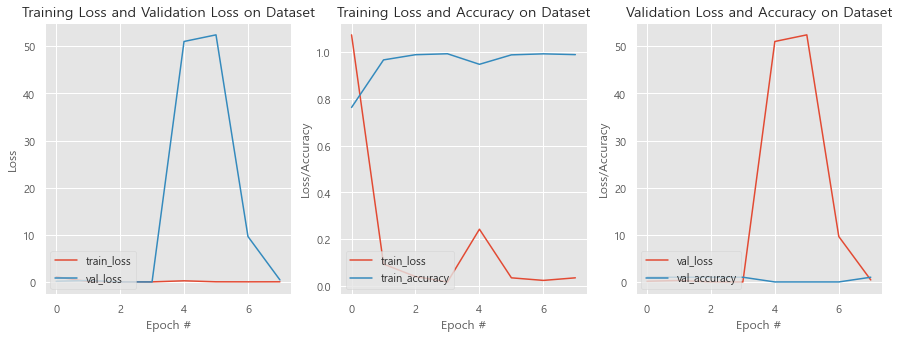

In [15]:
H, trained_model,train_generator,validation_generator, test_generator = train_model(model)
label_dict= get_label_dict(train_generator)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.save('/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5')

In [16]:
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.save('/content/drive/MyDrive/fragile/Classification/0712up_fragile_resnet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy',\
                      tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')\
                          ,tf.keras.metrics.FalsePositives(name='false_positives')\
                          ,tf.keras.metrics.FalseNegatives(name='false_negatives'),\
                      tf.keras.metrics.TruePositives(name ='true_positives'),\
                     tf.keras.metrics.TrueNegatives(name ='true_negatives')])
# #                      tf.keras.metrics.SensitivityAtSpecificity(specificity, num_thresholds=200, name='SensitivityAtSpecificity', dtype=None),\
#                      tf.keras.metrics.SpecificityAtSensitivity(name='SpecificityAtSensitivity')])

In [17]:
# 반환되는 "이력" 객체는 훈련 중 손실 값과 메트릭 값에 대한 레코드를 유지합니다.
H.history

{'loss': [1.0741735696792603,
  0.09325536340475082,
  0.039487551897764206,
  0.01659868285059929,
  0.24226507544517517,
  0.034227799624204636,
  0.023190172389149666,
  0.03423111513257027],
 'accuracy': [0.763477087020874,
  0.9669811129570007,
  0.9892183542251587,
  0.993261456489563,
  0.948113203048706,
  0.9885444641113281,
  0.9929245114326477,
  0.9895552396774292],
 'val_loss': [0.1518101543188095,
  0.3068862855434418,
  0.006746253930032253,
  9.893881360767409e-05,
  51.023223876953125,
  52.42830276489258,
  9.638599395751953,
  0.42783746123313904],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]}

In [25]:
result = model.evaluate(test_generator)
type(result)

374/374 [==============================] - 3s 9ms/step - loss: 1.9262 - accuracy: 0.6524 - precision: 0.6524 - recall: 0.6524 - false_positives: 130.0000 - false_negatives: 130.0000 - true_positives: 244.0000 - true_negatives: 244.0000


list

In [53]:
def evaluating_each(result):
    from keras import backend as K
    
    loss = result[0]
    accuracy = result[1]
    precision = result[2]
    recall = result[3]
    f_p = int(result[4])
    f_n = int(result[5])
    t_p = int(result[6])
    t_n = int(result[7])
    
    f1_score = (2 * recall * precision) / (recall + precision + K.epsilon())
    sensitivity = t_p / (t_p + f_n)
    specificity = t_n/ (t_n + f_p)
    
    print("""loss:{:.3f}, \naccuracy:{:.3f}, \nprecision:{:.3f}, \nrecall:{:.3f}, \nFalse_positive:{}, \nFalse_negative, :{}, \nTrue_positive:{}, \nTrue_negative:{}, \nSensitivity:{:.3f}, \nSpecificity:{:.3f}, \nF1_score:{:.3f}""".format(loss, accuracy, precision, recall, f_p, f_n, t_p, t_n, sensitivity, specificity, f1_score))
    return loss, accuracy, precision, recall, f_p, f_n, t_p, t_n, sensitivity, specificity, f1_score

In [54]:
evaluating_each(result)

loss:1.926, 
accuracy:0.652, 
precision:0.652, 
recall:0.652, 
False_positive:130, 
False_negative, :130, 
True_positive:244, 
True_negative:244, 
Sensitivity:0.652, 
Specificity:0.652, 
F1_score:0.652


(1.926223874092102,
 0.6524063944816589,
 0.6524063944816589,
 0.6524063944816589,
 130,
 130,
 244,
 244,
 0.6524064171122995,
 0.6524064171122995,
 0.6524063444816628)

In [61]:
grau

Instructions for updating:
Please use Model.predict, which supports generators.
374/374 [==============================] - 2s 5ms/step


(array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 

### save

In [41]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\weight

C:\Users\yukir\Documents\Monicas_workspace\Datasets\weight


In [70]:
model.save('[0723]data_default_resnet50.h5')

# Save model with json format 
model_json = model.to_json() 
with open("[0723]data_default_resnet50.json", "w") as json_file:
    json_file.write(model_json)
    
# Save weight with h5 format
model.save_weights("[0723]data_default_resnet50_weight.h5")
print("Saved model to disk")

Saved model to disk


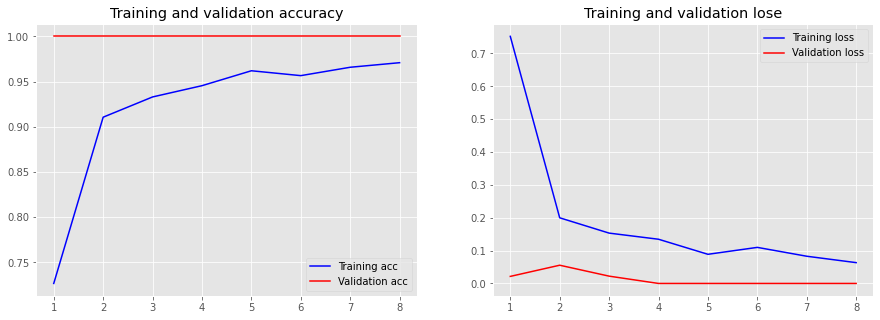

In [32]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

### evaluate

In [77]:
evaluating_each(model,test_generator)

374/374 [==============================] - 3s 9ms/step - loss: 1.9262 - accuracy: 0.6524 - precision: 0.6524 - recall: 0.6524 - false_positives: 130.0000 - false_negatives: 130.0000 - true_positives: 244.0000 - true_negatives: 244.0000

loss:1.926, 
accuracy:0.652, 
precision:0.652, 
recall:0.652, 
False_positive:130, 
False_negative, :130, 
True_positive:244, 
True_negative:244, 
Sensitivity:0.652, 
Specificity:0.652, 
F1_score:0.652


(1.926223874092102,
 0.6524063944816589,
 0.6524063944816589,
 0.6524063944816589,
 130,
 130,
 244,
 244,
 0.6524064171122995,
 0.6524064171122995,
 0.6524063444816628)

### real_pic test

In [80]:
test_gen_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\fragile sign\\test"

In [83]:
test_generator2 = ImageDataGenerator(test_gen_dir, rescale=1./255)

In [88]:
test_generator = test_generator2.flow_from_directory(preprocessing_function=preprocess_input,
                                                     "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\fragile sign\\test",
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=TEST_BATCH_SIZE,
                                                        shuffle = False,
                                                        class_mode='categorical')

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_3552/825715513.py, line 2)

In [89]:
test_generator = data_gen_default.flow_from_directory(preprocessing_function=preprocess_input,
            'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_3552/3702772686.py, line 2)

In [84]:
evaluating_each(model,test_generator2)

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>

### test set

In [52]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=False,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )

In [53]:
test_generator = data_generator_with_aug.flow_from_directory(
            "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\org_dir\\test",
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')

Found 744 images belonging to 2 classes.


In [62]:
test_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\org_dir\\test"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 744 images belonging to 2 classes.


In [82]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(test_set, batch_size=50)
print('\nloss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

24/24 [==============================] - ETA: 0s - loss: 0.6968 - acc: 0.5000 - precision: 0.5000 - recall: 0.5000 - false_positives: 352.0000 - false_negatives: 352.00 - 0s 19ms/step - loss: 0.6968 - acc: 0.5000 - precision: 0.5000 - recall: 0.5000 - false_positives: 372.0000 - false_negatives: 372.0000

loss: 0.697, accuracy: 0.500, precision: 0.500, recall: 0.500, false_positive: 372.000, false_negative: 372.000, f1score: 0.500


In [64]:
real_test_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\fragile sign"
test_datagen = ImageDataGenerator(rescale = 1./255)
real_test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 744 images belonging to 2 classes.


In [ ]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(test_generator, batch_size=50)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f},\
true_positive: {:.3f}, true_negative:: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision), ))

In [ ]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy',\
                      tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')\
                          ,tf.keras.metrics.FalsePositives(name='false_positives')\
                          ,tf.keras.metrics.FalseNegatives(name='false_negatives'),\
                      tf.keras.metrics.TruePositives(name ='true_positive'),\
                     tf.keras.metrics.TrueNegatives(name ='true_positive')])

### save

In [60]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\classification'

In [59]:
model.save('[0721]data_generator_resnet50.h5')

# Save model with json format 
model_json = model.to_json() 
with open("[0721]data_generator_resnet50.json", "w") as json_file:
    json_file.write(model_json)
    
# Save weight with h5 format
model.save_weights("[0721]data_generator_resnet50_weight.h5")
print("Saved model to disk")

Saved model to disk


### Real pic test

In [66]:
import os
test_img_path = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\fragile sign"
file_list = os.listdir(test_img_path)
file_list.sort
print(len(file_list))
list_file=[]
for i in file_list:
    list_file.append(test_img_path+i)
list_file.sort()
len(list_file)

18


18

In [68]:
file_name=[]
for i in list_file:
    name = i.split("\\")[-1]
    file_name.append(name)
file_name

['fragile signblankstock180501065.jpg',
 'fragile signgrunge-fragile-box-sign-with-arrow-up-on-piece-of-carton-for-logistics-or-cargo-and-alphabet-means-this-way-up-handle-with-care-vector-stencil-font-2DKJT9W.jpg',
 'fragile signimages (1).jpg',
 'fragile signimages.jpg',
 'fragile signresized_logistic_sign_test (10).jpg',
 'fragile signresized_logistic_sign_test (11).jpg',
 'fragile signresized_logistic_sign_test (12).jpg',
 'fragile signresized_logistic_sign_test (13).jpg',
 'fragile signresized_logistic_sign_test (14).jpg',
 'fragile signresized_logistic_sign_test (15).jpg',
 'fragile signresized_logistic_sign_test (16).jpg',
 'fragile signresized_logistic_sign_test (3).jpg',
 'fragile signresized_logistic_sign_test (4).jpg',
 'fragile signresized_logistic_sign_test (5).jpg',
 'fragile signresized_logistic_sign_test (6).jpg',
 'fragile signresized_logistic_sign_test (7).jpg',
 'fragile signresized_logistic_sign_test (8).jpg',
 'fragile signresized_logistic_sign_test (9).jpg']

In [70]:
test_df = pd.DataFrame({'file_name':file_name})
nbsamples=test_df.shape[0]
nbsamples

18

In [46]:
batch_size=15

In [47]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=False,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5])
                               

In [73]:
test_generator = data_generator_with_aug.flow_from_directory(
            real_test_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')

Found 18 images belonging to 1 classes.


In [71]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [74]:
predict=model.predict_generator(test_generator, 
                                steps=nbsamples/TEST_BATCH_SIZE, 
                                callbacks=callbacks)
                                
test_df['category']=np.argmax(predict, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [77]:
test_df['category']=test_df['category'].replace({0:'fragile',1:"up"})
ex_df=test_df.sample(n=1).reset_index(drop=True)
ex_df

,file_name,category
0,fragile signresized_logistic_sign_test (12).jpg,up


In [34]:
b = get_label_dict(train_generator)
b

{0: 'fragile', 1: 'up'}

In [92]:
test_df.head(7)

,file_name,category
0,fragile signblankstock180501065.jpg,fragile
1,fragile signgrunge-fragile-box-sign-with-arrow...,up
2,fragile signimages (1).jpg,fragile
3,fragile signimages.jpg,up
4,fragile signresized_logistic_sign_test (10).jpg,up
5,fragile signresized_logistic_sign_test (11).jpg,fragile
6,fragile signresized_logistic_sign_test (12).jpg,up


In [93]:
test_df.category.value_counts()

fragile    10
up          8
Name: category, dtype: int64